In [1]:
#########
# IMPORTS
#########
import random as rand
import tensorflow as tf
import networkx as nx
import numpy as np
import pandas as pd
import time
import pickle
from tsp_solver.greedy import solve_tsp as solve
from graph_nets import utils_tf
from graph_nets import utils_np
from graph_nets.demos import models


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
#########
# UTILS
#########

def create_random_graph(node_range=(5, 9), prob=0.25, weight_range=(1, 10)):
    '''
    This function generates a Hamiltonian graph by generating a complete graph
    with random initial weights.
    '''
    n_nodes = rand.randint(*node_range)

    G = nx.complete_graph(n_nodes)
    H = G.copy()
    for u, v, w in G.edges(data=True):
        H[u][v]["weight"] = rand.randint(*weight_range)

    return H

def solve_tsp(graph):
    '''
    This function solves the TSP problem in a graph with a TSP solver from third-party library
    '''
    adj_matrix = nx.adjacency_matrix(graph)
    hamil_path = solve(adj_matrix.todense().tolist())

    path_edges = [(hamil_path[i], hamil_path[i + 1])
                  for i in range(len(hamil_path) - 1)]
    path_edges.append((hamil_path[-1], hamil_path[0]))

    for u, v in graph.edges():
        graph[u][v]["solution"] = int(
            any({u, v}.issubset({src, targ}) for src, targ in path_edges))

    solution_dict = {v: False for v in graph.nodes()}
    for u, v in path_edges:
        solution_dict[u] = True
        solution_dict[v] = True

    nx.set_node_attributes(graph, solution_dict, "solution")

    return graph

def to_one_hot(indices, max_value, axis=-1):
    '''
    pad a one hot vector
    '''
    one_hot = np.eye(max_value)[indices]
    if axis not in (-1, one_hot.ndim):
        one_hot = np.moveaxis(one_hot, -1, axis)

    return one_hot

def graph_to_input_target(graph):
    '''
    from a Hamiltonian graph that contains all information,
    this function generates an input graph and a target graph
    with the necessary information encoded in each graph.
    '''
    def create_feature(attr, fields):
        return np.hstack([np.array(attr[field], dtype=float) for field in fields])

    # feature fields
    input_node_fields = ("solution",)
    input_edge_fields = ("weight",)
    target_node_fields = ("solution",)
    target_edge_fields = ("solution",)

    input_graph = graph.copy()
    target_graph = graph.copy()

    # Generate Node Features
    solution_length = 0
    for node_index, node_feature in graph.nodes(data=True):
        input_graph.add_node(
            node_index, features=create_feature(node_feature, input_node_fields))
        target_node = to_one_hot(
            create_feature(node_feature, target_node_fields).astype(int), 2)[0]
        target_graph.add_node(node_index, features=target_node)

    # Generate Edge Features
    for receiver, sender, features in graph.edges(data=True):
        input_graph.add_edge(
            sender, receiver, features=create_feature(features, input_edge_fields))
        target_edge = to_one_hot(
            create_feature(features, target_edge_fields).astype(int), 2)[0]
        target_graph.add_edge(sender, receiver, features=target_edge)
        solution_length += features["weight"] * features["solution"]

    input_graph.graph["features"] = np.array([0.0])
    target_graph.graph["features"] = np.array([solution_length], dtype=float)

    return input_graph, target_graph

def generate_networkx_graphs(num_graphs, node_range=(5, 9), prob=0.25, weight_range=(1, 10)):
    '''
    generate_nx_graphs wraps up the previous functions
    and serves as a helper function to conveniently
    generates graphs for training/testing
    '''
    input_graphs = []
    target_graphs = []
    graphs = []

    for i in range(num_graphs):
        graph = create_random_graph(node_range, prob, weight_range)
        graph = solve_tsp(graph)
        input_graph, target_graph = graph_to_input_target(graph)
        input_graphs.append(input_graph)
        target_graphs.append(target_graph)
        graphs.append(graph)

    return input_graphs, target_graphs, graphs


#########
# EXPORTS
#########

def create_placeholders(num_graphs):
    '''
    Create a placeholder for feeding graphs to the NN uses API
    provided by deepming GNN library to do that
    '''
    input_graphs, target_graphs, _ = generate_networkx_graphs(num_graphs)
    input_ph = utils_tf.placeholders_from_networkxs(input_graphs)
    target_ph = utils_tf.placeholders_from_networkxs(target_graphs)
    return input_ph, target_ph

def make_all_runnable_in_session(*args):
    '''
    Lets an iterable of TF graphs be output from a session as NP graphs.
    '''
    return [utils_tf.make_runnable_in_session(a) for a in args]

def create_feed_dict(num_graphs, input_ph, target_ph):
    '''
    Creates placeholders for the model training and evaluation.
    '''

    inputs, targets, raw_graphs = generate_networkx_graphs(num_graphs)
    input_graphs = utils_np.networkxs_to_graphs_tuple(inputs)
    target_graphs = utils_np.networkxs_to_graphs_tuple(targets)
    feed_dict = {input_ph: input_graphs, target_ph: target_graphs}

    return feed_dict, inputs

In [3]:
#########
# TRAINING_HELPER (THAT CAN BE TUNED)
#########

def create_loss_ops(target_op, output_ops):
    '''
    use edge information for computing losses
    '''
    return [
        tf.losses.softmax_cross_entropy(target_op.edges, output_op.edges)
        for output_op in output_ops
    ]

def compute_accuracy(target, output, use_nodes=True, use_edges=False):
    '''
    Compute classification accuracy
    '''
    if not use_nodes and not use_edges:
        raise ValueError("Nodes or edges (or both) must be used")

    tdds = utils_np.graphs_tuple_to_data_dicts(target)
    odds = utils_np.graphs_tuple_to_data_dicts(output)

    cs, ss = [], []
    for td, od in zip(tdds, odds):

        xe = np.argmax(td["edges"], axis=-1)
        ye = np.argmax(od["edges"], axis=-1)

        c = [xe == ye] if use_edges else []
        c = np.concatenate(c, axis=0)

        s = np.all(c)
        cs.append(c)
        ss.append(s)

    correct = np.mean(np.concatenate(cs, axis=0))
    solved = np.mean(np.stack(ss))

    return correct, solved

In [4]:
#########
# MODEL AND HYPERPARAMETERS SETUP
#########
tf.reset_default_graph()

seed = 2
rand = np.random.RandomState(seed=seed)

# Model parameters; no. of message-passing steps
num_processing_steps_tr = 10
num_processing_steps_ge = 10

# Data / training parameters
num_training_iterations = 2000
batch_size_tr = 200
batch_size_ge = 50

# Input and target placeholders
input_ph, target_ph = create_placeholders(batch_size_tr)

# Connect the data to the model and instantiate
model = models.EncodeProcessDecode(edge_output_size=2, node_output_size=2)
# A list of outputs, one per processing step
output_ops_tr = model(input_ph, num_processing_steps_tr)
output_ops_ge = model(input_ph, num_processing_steps_ge)

# Training loss
loss_ops_tr = create_loss_ops(target_ph, output_ops_tr)
# Loss across processing steps
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr
# Test/generalization loss
loss_ops_ge = create_loss_ops(target_ph, output_ops_ge)
loss_op_ge = loss_ops_ge[-1]  # Loss from final processing step

# Optimizer
learning_rate = 1.3e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

# Lets an iterable of TF graphs be output from a session as NP graphs
input_ph, target_ph = make_all_runnable_in_session(input_ph, target_ph)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


/Users/roger/Library/Python/3.7/lib/python/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [5]:
#########
# RESET SESSION
#########
try:
    sess.close()
except NameError:
    pass

sess = tf.Session()
sess.run(tf.global_variables_initializer())

last_iteration = 0
logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
losses_ge = []
corrects_ge = []
solveds_ge = []

In [6]:
#########
# TRY TO RESTORE THE MODEL
#########
restored_model_flag = False
try:
    saver = tf.train.Saver()
    saver.restore(sess, "data/pickles/model.ckpt")
    restored_model_flag = True
    print("USING MODEL FOUND ON LOCAL STORAGE")
except ValueError:
    pass

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from data/pickles/model.ckpt
USING MODEL FOUND ON LOCAL STORAGE


In [7]:
#########
# TRAINING
#########
# How much time between logging and printing the current results.
log_every_seconds = 20

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training loss), Lge (test/generalization loss), "
      "Ctr (training fraction nodes/edges labeled correctly), "
      "Str (training fraction examples solved correctly), "
      "Cge (test/generalization fraction nodes/edges labeled correctly), "
      "Sge (test/generalization fraction examples solved correctly)")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
    last_iteration = iteration

    feed_dict, _ = create_feed_dict(batch_size_tr, input_ph, target_ph)
    train_values = sess.run({
        "step": step_op,
        "target": target_ph,
        "loss": loss_op_tr,
        "outputs": output_ops_tr
    }, feed_dict=feed_dict)

    the_time = time.time()
    elapsed_since_last_log = the_time - last_log_time

    if elapsed_since_last_log > log_every_seconds:
        last_log_time = the_time

        feed_dict, raw_graphs = create_feed_dict(
            batch_size_ge, input_ph, target_ph)
        test_values = sess.run({
            "target": target_ph,
            "loss": loss_op_ge,
            "outputs": output_ops_ge
        }, feed_dict=feed_dict)

        correct_tr, solved_tr = compute_accuracy(
            train_values["target"], train_values["outputs"][-1], use_edges=True)
        correct_ge, solved_ge = compute_accuracy(
            test_values["target"], test_values["outputs"][-1], use_edges=True)

        elapsed = time.time() - start_time

        losses_tr.append(train_values["loss"])
        corrects_tr.append(correct_tr)
        solveds_tr.append(solved_tr)
        losses_ge.append(test_values["loss"])
        corrects_ge.append(correct_ge)
        solveds_ge.append(solved_ge)
        logged_iterations.append(iteration)

        print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge {:.4f}, Ctr {:.4f}, Str"
              " {:.4f}, Cge {:.4f}, Sge {:.4f}".format(
                  iteration, elapsed, train_values["loss"], test_values["loss"],
                  correct_tr, solved_tr, correct_ge, solved_ge))
        if restored_model_flag and True: # change True to False to continue Training from last time
            print("Breaking...")
            break

# (iteration number), T (elapsed seconds), Ltr (training loss), Lge (test/generalization loss), Ctr (training fraction nodes/edges labeled correctly), Str (training fraction examples solved correctly), Cge (test/generalization fraction nodes/edges labeled correctly), Sge (test/generalization fraction examples solved correctly)
# 00030, T 21.3, Ltr 0.3545, Lge 0.2811, Ctr 0.8713, Str 0.1350, Cge 0.8835, Sge 0.2400


In [8]:
#########
# POST-TRAINING TESTING
#########
test_batch_size = 1000
num_processing_steps_test = 10

test_input_ph, test_target_ph = create_placeholders(test_batch_size)
test_output_ops = model(test_input_ph, num_processing_steps_test)

test_loss_ops = create_loss_ops(test_target_ph, test_output_ops)
test_loss_op = test_loss_ops[-1]

test_input_ph, test_target_ph = make_all_runnable_in_session(
    test_input_ph, test_target_ph)

test_feed_dict, test_input_graphs = create_feed_dict(
    test_batch_size, test_input_ph, test_target_ph)
test_values = sess.run({
    "target": test_target_ph,
    "loss": test_loss_op,
    "outputs": test_output_ops
}, feed_dict=test_feed_dict)

In [9]:
#########
# MODEL & RESULTS STORAGE
#########


# Store the model
saver = tf.train.Saver()
saver.save(sess, "data/pickles/model.ckpt")

# Store the training statistics
train_stats = pd.DataFrame(np.array([logged_iterations, losses_tr, losses_ge,
                                     corrects_tr, solveds_tr, corrects_ge, solveds_ge]).T,
                           columns=["iteration", "loss_tr", "loss_ge", "correct_tr", "solved_tr",
                                    "correct_ge", "solved_ge"])
train_stats.to_pickle("data/pickles/train_stats.pkl")

output_graphs = utils_np.graphs_tuple_to_networkxs(test_values["outputs"][-1])
target_graphs = utils_np.graphs_tuple_to_networkxs(test_values["target"])
input_graphs = test_input_graphs

# Store the test results
pickle.dump({
    "outputs": output_graphs,
    "targets": target_graphs,
    "inputs": input_graphs,
}, open("data/pickles/test_results.pkl", "wb"))

In [36]:
#########
# EVAL HELPERS
#########
def is_solution_edge(feature_vector):
    '''
    Given a feature vector of an edge, determines if it's classified as solution
    '''
    # if it's solution, one hot vector is (0, 1)
    if feature_vector[1] > feature_vector[0]: return True
    return False

def get_neighbor_dict(my_graph):
    '''
    return a dictionary with vertices as key each item contains its neighbor
    vertices connected by the labelled edges
    '''
    ret_dict = {}
    edge_list = [i for i in my_graph.edges(data = True)]
    output_label_cnt = 0
    for i in edge_list:
        if is_solution_edge(i[2]["features"]):
            try:
                ret_dict[i[0]].append(i[1])
            except KeyError:
                ret_dict[i[0]] = [i[1]]
            try:
                ret_dict[i[1]].append(i[0])
            except KeyError:
                ret_dict[i[1]] = [i[0]]
            output_label_cnt += 1
    return ret_dict, output_label_cnt

def hamiltonian_path_check(my_graph):
    '''
    Check if a the solution to a graph is Hamiltonian
    '''
    neighbor_dict, my_count = get_neighbor_dict(my_graph)
    my_vertices = [i for i in my_graph.nodes()]
    visited_dict = [False] * len(my_vertices)
    # since hamiltonian path is closed; choose a random vertex to start
    # actually nvm, maybe just use the first vertex...
    start_vertex = my_vertices[0]
    # test 1: every vertex is in the neighbor_dict
    for v in my_vertices:
        try:
            neighbor_dict[v]
        except KeyError:
            return False, neighbor_dict, my_count
    # test 2: every vertex connects to two and only two other vertices
    for k, i in neighbor_dict.items():
        if len(i) != 2: return False, neighbor_dict, my_count
    # test 3: start from a node and perform the walk, we will end up at the same node
    current_vertex = start_vertex
    next_vertex = neighbor_dict[start_vertex][0]
    while True:
        visited_dict[current_vertex] = True
        if next_vertex == start_vertex: break
        if neighbor_dict[next_vertex][0] == current_vertex:
            current_vertex = next_vertex
            next_vertex = neighbor_dict[next_vertex][1]
        else:
            current_vertex = next_vertex
            next_vertex = neighbor_dict[next_vertex][0]
    for mark in visited_dict:
        if mark == False: return False, neighbor_dict, my_count
    return True, neighbor_dict, my_count

def get_ori_weight(input_graph, u, v):
    '''
    Given the original graph and vertices u, v, return its original weights
    '''
    return input_graph.get_edge_data(u, v)["weight"]

def evaluate(input_graphs, output_graphs, target_graphs):
    '''
    Main Evaluate function that does all the job
    '''
    assert len(output_graphs) == len(target_graphs)
    assert len(input_graphs) == len(output_graphs)
    assert isinstance(output_graphs, list)
    assert isinstance(target_graphs, list)

    n_num = len(output_graphs)

    # sort graph by correctly labelled edges
    # seperate output into bad/average/good sets

    is_hamiltonian_path_count = 0
    recall_correct_count = 0
    recall_total_count = 0
    precision_total_count = 0

    output_solution_len_list = []
    target_solution_len_list = []

    non_output_soln_len_list = []
    non_target_soln_len_list = []

    for i in range(len(output_graphs)):
        ret, my_dict, my_count = hamiltonian_path_check(output_graphs[i])
        precision_total_count += my_count
        if ret:
            is_hamiltonian_path_count += 1
        # get output solution length
        output_soln_len = 0
        for u in my_dict.keys():
            for v in my_dict[u]:
                if u > v: continue
                output_soln_len += get_ori_weight(input_graphs[i], u, v)
        # get target solution length
        tar_soln_len = 0
        for e in input_graphs[i].edges(data = True):
            if e[2]["solution"] == 1:
                tar_soln_len += e[2]["weight"]
                recall_total_count += 1
                try:
                    for neighboring_vertex in my_dict[e[0]]:
                        if neighboring_vertex == e[1]:
                            recall_correct_count += 1
                            break
                except KeyError:
                    pass
            output_solution_len_list.append(output_soln_len)
            target_solution_len_list.append(tar_soln_len)
            non_output_soln_len_list.append(output_soln_len)
            non_target_soln_len_list.append(tar_soln_len)
    # calculate difference between output and target graphs
    print("{0} out of {1} solutions are Hamiltonian.".format(is_hamiltonian_path_count, n_num))
    output_solution_len_list = np.array(output_solution_len_list)
    target_solution_len_list = np.array(target_solution_len_list)
    diff_ = output_solution_len_list - target_solution_len_list
    print("Among Hamiltonian cycles found by the GNN, the average difference in solution graph with ground truth is {0:.4f}".format(np.mean(diff_)))
    output_vec = np.array(non_output_soln_len_list)
    target_vec = np.array(non_target_soln_len_list)
    diff_ = output_vec - target_vec
    print("Among those that were incorrectly labelled, the average error in solution length is {0:.4f}".format(np.mean(diff_)))
    total_weight = 0
    for g in input_graphs:
        for e in g.edges(data = True):
            total_weight += e[2]["weight"]
    average_weight = total_weight / n_num
    print("On average, the total weight of each graph we used is {0:.4f}. So the average relative error is {1:.4f}".format(average_weight, np.mean(diff_) / average_weight))
    print("Recall: {0:.4f}".format(recall_correct_count / recall_total_count))
    print("Precision: {0:.4f}".format(recall_correct_count / precision_total_count))

In [37]:
evaluate(input_graphs, output_graphs, target_graphs)

184 out of 1000 solutions are Hamiltonian.
Among Hamiltonian cycles found by the GNN, the average difference in solution graph with ground truth is 6.0105
Among those that were incorrectly labelled, the average error in solution length is 6.0105
On average, the total weight of each graph we used is 92.5670. So the average relative error is 0.0649
Recall: 0.7891
Precision: 0.8387


<Figure size 720x360 with 0 Axes>

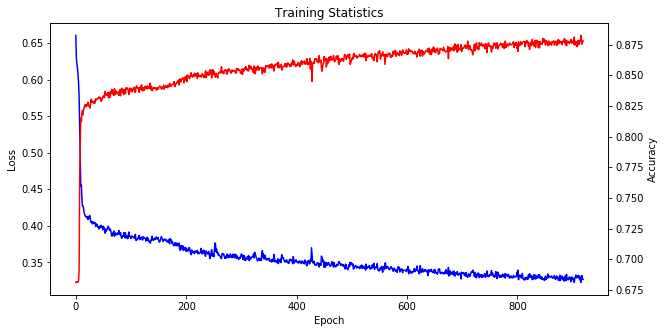

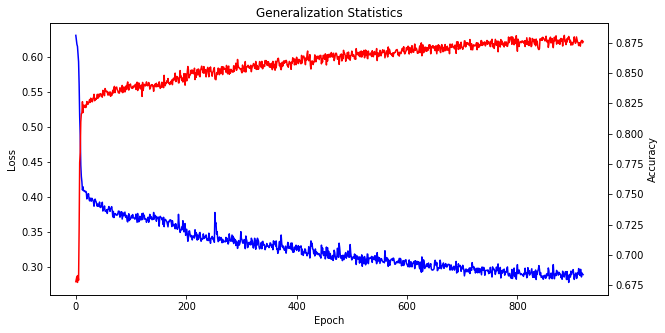

<Figure size 720x360 with 0 Axes>

In [90]:
#########
# MAKE TRAINING STATS
#########
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

training_stats = pickle.load(open("data/pickles/train_stats.pkl", 'rb'))

# Make Training Plots
loss_tr = np.array(training_stats['loss_tr'])
correct_tr = np.array(training_stats['correct_tr'])
epoch = np.arange(loss_tr.shape[0])
ax = plt.subplot(1, 1, 1)
ax.plot(epoch, loss_tr, label = "Training Loss", color = "blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# Accuracy (right)
ax2 = ax.twinx()
ax2.plot(epoch, correct_tr, label = "Training Accuracy", color = "red")
plt.ylabel('Accuracy')
plt.title("Training Statistics")
plt.savefig("training_stats.png")
plt.figure()

# Make Testing Plots
# Make Training Plots
loss_ge = np.array(training_stats['loss_ge'])
correct_ge = np.array(training_stats['correct_ge'])
epoch = np.arange(loss_ge.shape[0])
ax = plt.subplot(1, 1, 1)
ax.plot(epoch, loss_ge, color = "blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# Accuracy (right)
ax2 = ax.twinx()
ax2.plot(epoch, correct_ge, color = "red")
plt.ylabel('Accuracy')
plt.title("Generalization Statistics")
plt.savefig("generalization_stats.png")
plt.figure()